# Redes Neurais

Este notebook serve como um guia introdutório ao desenvolvimento de redes neurais utilizando a biblioteca PyTorch. Abordaremos os componentes fundamentais da biblioteca, desde a manipulação de tensores até a construção e o treinamento de um modelo de rede neural para classificação de imagens.

## Conteúdos Abordados

1.  **Tensores e Grafos Computacionais**: A base do PyTorch.
2.  **O Módulo `torch.nn`**: Construindo camadas da rede.
3.  **Funções de Ativação**: Introduzindo não linearidade.
4.  **Construindo Modelos**: `nn.Sequential` e classes customizadas com `nn.Module`.
5.  **Datasets e DataLoaders**: Gerenciando e preparando dados com o `torchvision`.
6.  **Funções de Custo (Loss Functions)**: Quantificando o erro do modelo.
7.  **Otimizadores**: Atualizando os pesos do modelo.
8.  **Treinamento**: O ciclo completo de forward, backward e otimização.

## 1. Tensores e Grafos Computacionais

O `Tensor` é a estrutura de dados central do PyTorch. Trata-se de uma matriz multidimensional otimizada para operações em hardware especializado como GPUs. Os tensores são a base para a construção de grafos computacionais dinâmicos, que são essenciais para o cálculo automático de gradientes através do mecanismo de diferenciação automática, conhecido como `autograd`.

In [ ]:
import torch

# Criando um tensor a partir de uma lista Python
data_list = [[1, 2], [3, 4]]
x_data = torch.tensor(data_list, dtype=torch.float32)
print(f"Tensor a partir de lista:\n {x_data}\n")

# Funções de criação de tensores
x_ones = torch.ones_like(x_data) # Cria um tensor de 'uns' com o mesmo formato de x_data
print(f"Tensor de 'uns':\n {x_ones} \n")

x_rand = torch.rand_like(x_data, dtype=torch.float) # Cria um tensor com valores aleatórios
print(f"Tensor aleatório:\n {x_rand} \n")

### O Grafo Computacional e o `autograd`

O coração do PyTorch é o `autograd`, seu mecanismo de diferenciação automática. Para que o `autograd` funcione, ele constrói um **grafo computacional** dinamicamente. Este grafo é uma representação de todas as operações executadas nos tensores.

Nesta seção, vamos decompor passo a passo como esse grafo é construído e utilizado para calcular gradientes, usando como exemplo a função:
$$
L = (ab - c)^2
$$

#### Passo 1: Definindo os Tensores Folha com `requires_grad`

O processo começa com a definição dos tensores de entrada. Estes são as "folhas" do nosso grafo. Para que o PyTorch rastreie as operações e calcule os gradientes em relação a eles, devemos definir seu atributo `requires_grad` como `True`.

In [ ]:
import torch

# Definindo os tensores de entrada (folhas do grafo)
# Estes são os parâmetros em relação aos quais queremos os gradientes
a = torch.tensor(4.0, requires_grad=True)
b = torch.tensor(5.0, requires_grad=True)
c = torch.tensor(2.0, requires_grad=True)

print(f"Tensor 'a': {a}")
print(f"Tensor 'b': {b}")
print(f"Tensor 'c': {c}")

#### Passo 2: Construindo o Grafo no Forward Pass

À medida que executamos as operações (o *forward pass*), o PyTorch constrói o grafo dinamicamente. Cada novo tensor resultante de uma operação armazena uma referência à função que o criou através do atributo `grad_fn`. Isso cria uma "história" computacional que permite a retropropagação.

In [ ]:
# Executando o forward pass para construir o grafo
z = a * b - c
L = z**2

print(f"Resultado intermediário 'z': {z}")
print(f"  - z.grad_fn: {z.grad_fn}\n") # z foi criado por uma subtração (SubBackward0)

print(f"Resultado final 'L': {L}")
print(f"  - L.grad_fn: {L.grad_fn}") # L foi criado por uma potenciação (PowBackward0)

#### Passo 3: Calculando os Gradientes com `.backward()`

Com o grafo construído, podemos calcular os gradientes usando o método `.backward()` no tensor de saída final (que deve ser um escalar). Esta chamada inicia o processo de retropropagação a partir de `L`, aplicando a regra da cadeia para calcular as derivadas parciais de `L` em relação a cada tensor folha.

Para o nosso exemplo, o `autograd` calcula:
$$
\frac{\partial L}{\partial a} = \frac{\partial L}{\partial z}\frac{\partial z}{\partial a} = 2(ab - c)b
$$
E de forma análoga para `b` e `c`.

In [ ]:
# Inicia a retropropagação a partir de L
L.backward()
print("O método L.backward() foi executado.")

#### Passo 4: Acessando os Gradientes Calculados

Após a execução de `.backward()`, os gradientes calculados são acumulados no atributo `.grad` dos tensores folha (aqueles que foram inicializados com `requires_grad=True`).

In [ ]:
# Os gradientes agora estão disponíveis no atributo .grad de cada tensor folha
print(f"Gradiente dL/da: {a.grad}")
print(f"  - Cálculo manual: 2 * (4*5 - 2) * 5 = {2 * (4*5 - 2) * 5.0}\n")

print(f"Gradiente dL/db: {b.grad}")
print(f"  - Cálculo manual: 2 * (4*5 - 2) * 4 = {2 * (4*5 - 2) * 4.0}\n")

print(f"Gradiente dL/dc: {c.grad}")
print(f"  - Cálculo manual: 2 * (4*5 - 2) * (-1) = {2 * (4*5 - 2) * (-1.0)}")

#### Desligando o Rastreamento com `torch.no_grad()`

Para fases de inferência ou avaliação, onde não precisamos de gradientes, é crucial desativar o rastreamento para economizar memória e acelerar a computação. O gerenciador de contexto `with torch.no_grad():` instrui o PyTorch a não construir o grafo computacional para nenhuma operação dentro de seu escopo.

In [ ]:
print(f"Rastreamento de gradientes está ativado por padrão para 'a': {a.requires_grad}")

with torch.no_grad():
    print("--- Entrando no bloco no_grad ---")

    # A mesma operação é executada aqui
    L_no_grad = (a * b - c)**2

    print(f"Resultado L_no_grad: {L_no_grad}")
    # O tensor resultante não possui grad_fn, pois a operação não foi rastreada
    print(f"L_no_grad.grad_fn: {L_no_grad.grad_fn}")
    print(f"L_no_grad.requires_grad: {L_no_grad.requires_grad}")

    print("--- Saindo do bloco no_grad ---")

print(f"O rastreamento de gradientes para 'a' continua ativado fora do bloco: {a.requires_grad}")

## 2. O Módulo `torch.nn`

O `torch.nn` é o módulo do PyTorch para a construção de redes neurais. Ele fornece um conjunto de blocos de construção, como camadas (`Layers`), funções de ativação (`Activation Functions`), funções de custo (`Loss Functions`) e contêineres (`Containers`). Uma "camada" no `torch.nn` é um objeto que encapsula tanto os pesos (parâmetros) quanto as operações a serem aplicadas nos dados de entrada.

### Camada Linear: `nn.Linear`

A camada mais fundamental é a `nn.Linear`, que aplica uma transformação afim aos dados de entrada: $y = xW^T + b$.

-   `in_features`: a dimensionalidade do espaço de entrada.
-   `out_features`: a dimensionalidade do espaço de saída.

Os tensores de peso (`weight`, $W$) e de viés (`bias`, $b$) são encapsulados como `nn.Parameter`, uma subclasse de `torch.Tensor` que os registra automaticamente como parâmetros de um `nn.Module`.

In [ ]:
from torch import nn

# Definindo uma camada linear
# Entrada: 10 features
# Saída: 5 features
linear_layer = nn.Linear(in_features=10, out_features=5)

# Criando um tensor de entrada de exemplo (um "batch" com 3 amostras)
# O formato é (batch_size, in_features)
input_tensor = torch.randn(3, 10)

# Passando os dados pela camada
output_tensor = linear_layer(input_tensor)

print(f"Formato do tensor de entrada: {input_tensor.shape}")
print(f"Formato do tensor de saída: {output_tensor.shape}")
print(f"\nPesos (weights) da camada:\n {linear_layer.weight.shape}")
print(f"Viés (bias) da camada:\n {linear_layer.bias.shape}")

## 3. Funções de Ativação

Funções de ativação introduzem não linearidade no modelo, capacitando-o a aprender fronteiras de decisão complexas. Elas são aplicadas elemento a elemento na saída de uma camada.

### Funções Comuns

-   **Sigmoid**: Comprime os valores de entrada no intervalo $(0, 1)$. Utilizada historicamente em camadas ocultas e atualmente em camadas de saída para classificação binária.
    $$ \sigma(x) = \frac{1}{1 + e^{-x}} $$
-   **Tanh (Tangente Hiperbólica)**: Comprime os valores de entrada no intervalo $(-1, 1)$. Geralmente converge mais rápido que a Sigmoid por ser centrada em zero.
    $$ \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} $$
-   **ReLU (Rectified Linear Unit)**: A função de ativação mais utilizada em redes profundas. É computacionalmente eficiente e ajuda a mitigar o problema do desaparecimento do gradiente (vanishing gradient).
    $$ \text{ReLU}(x) = \max(0, x) $$
-   **Leaky ReLU**: Uma variação da ReLU que permite a passagem de um pequeno gradiente negativo, prevenindo o problema dos "neurônios mortos".
    $$ \text{LeakyReLU}(x) = \begin{cases} x, & \text{if } x > 0 \\ \alpha x, & \text{otherwise} \end{cases} $$
-   **Softmax**: Transforma um vetor de números reais (logits) em uma distribuição de probabilidade sobre múltiplas classes. Utilizada na camada de saída para classificação multiclasse.
    $$ \text{Softmax}(x_i) = \frac{e^{x_i}}{\sum_{j} e^{x_j}} $$

In [ ]:
# As funções de ativação também estão no módulo nn
relu_activation = nn.ReLU()
leaky_relu_activation = nn.LeakyReLU()

# Aplicando a ativação na saída da camada linear anterior
output_with_relu = relu_activation(output_tensor)
output_with_leaky_relu = leaky_relu_activation(output_tensor)

print(f"Saída da camada linear:\n {output_tensor}\n")
print(f"Saída após ativação ReLU:\n {output_with_relu}\n")
print(f"Saída após ativação Leaky ReLU:\n {output_with_leaky_relu}")

## 4. Construindo Modelos

O PyTorch oferece duas maneiras principais de agrupar camadas para formar um modelo completo.

### `nn.Sequential`

`nn.Sequential` é um contêiner que recebe uma sequência de módulos (camadas, funções de ativação, etc.) e os executa na ordem em que são passados. É uma forma rápida e simples de criar modelos onde os dados fluem sequencialmente através das camadas.

In [ ]:
# Construindo um modelo simples com nn.Sequential
model_sequential = nn.Sequential(
    nn.Linear(in_features=256, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=10)
)

# Criando um tensor de entrada de exemplo
inputs = torch.randn(64, 256)

# Forward pass através do modelo sequencial
logits = model_sequential(inputs) # 'logits' são as saídas brutas antes da probabilidade

print(f"Formato da saída do modelo: {logits.shape}")

### Classes customizadas com `nn.Module`

Para modelos mais complexos, como aqueles com múltiplos caminhos de entrada/saída ou lógicas de *forward pass* não sequenciais (e.g., redes residuais), a abordagem recomendada é criar uma classe que herda de `nn.Module`.

Toda classe de modelo customizada deve:
1.  Herdar de `torch.nn.Module`.
2.  Definir as camadas no construtor `__init__(self)`.
3.  Implementar a lógica do *forward pass* no método `forward(self, x)`.

O método `backward()` é gerenciado automaticamente pelo `autograd`.

In [ ]:
# Definindo o mesmo modelo anterior, mas agora como uma classe
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        return out

# Instanciando o modelo
model_class = NeuralNetwork(input_size=256, hidden_size=128, num_classes=10)

# O uso é idêntico
logits_class = model_class(inputs)

print(f"Formato da saída do modelo (classe): {logits_class.shape}")
print(f"\nEstrutura do modelo:\n{model_class}")

## 5. Datasets e DataLoaders

Para treinar um modelo, precisamos de um pipeline de dados eficiente. O PyTorch oferece duas primitivas de dados fundamentais para isso: `torch.utils.data.Dataset` e `torch.utils.data.DataLoader`.

### A Estrutura de um `Dataset` Customizado

A classe `Dataset` é uma classe abstrata que representa uma fonte de dados. Para criar seu próprio dataset, você precisa herdar desta classe e sobrescrever três métodos especiais (métodos mágicos):

1.  `__init__(self, ...)`: O construtor da classe. É executado uma única vez ao instanciar o dataset. É aqui que você normalmente faria o carregamento inicial dos dados (ex: ler um arquivo CSV, encontrar os caminhos das imagens em um diretório).

2.  `__len__(self)`: Este método deve retornar o número total de amostras no seu dataset. O `DataLoader` utiliza essa informação para saber o tamanho do dataset e definir os índices.

3.  `__getitem__(self, idx)`: Este método é responsável por carregar e retornar **uma única amostra** do dataset, dado um índice `idx`. É aqui que transformações nos dados (como data augmentation ou normalização) são frequentemente aplicadas.

In [ ]:
from torch.utils.data import Dataset

# Exemplo prático de um Dataset customizado com tensores
class SimpleTensorDataset(Dataset):
    def __init__(self, features_tensor, labels_tensor):
        self.features = features_tensor
        self.labels = labels_tensor

    def __len__(self):
        # Retorna o número total de amostras
        return self.features.size(0)

    def __getitem__(self, idx):
        # Retorna uma tupla (feature, label) para um dado índice
        feature_sample = self.features[idx]
        label_sample = self.labels[idx]
        return feature_sample, label_sample

# Criando dados de exemplo
features = torch.randn(500, 64) # 500 amostras, 64 features cada
labels = torch.randint(0, 2, (500,)) # 500 rótulos (0 ou 1)

# Instanciando o nosso dataset customizado
custom_dataset = SimpleTensorDataset(features, labels)

# Verificando a implementação dos métodos
print(f"Tamanho total do dataset: {len(custom_dataset)}")

In [ ]:
# Pegando a primeira amostra (chamando __getitem__ com idx=0)
first_sample_features, first_sample_label = custom_dataset[0]
print(f"Primeira amostra (features): {first_sample_features.shape}")
print(f"Primeira amostra (label): {first_sample_label}")

### O Papel do `DataLoader`

Uma vez que temos um objeto `Dataset`, que sabe como acessar amostras individuais, precisamos de uma forma eficiente de iterar sobre ele durante o treinamento. É aqui que entra o `DataLoader`.

O `DataLoader` é um iterador que envolve um `Dataset` e automatiza o processo de criação de mini-lotes (*mini-batches*). Suas principais funcionalidades são:

-   **Agrupamento em Lotes (Batching)**: Agrupa múltiplas amostras retornadas pelo `__getitem__` do `Dataset` para formar um lote (batch) de dados.
-   **Embaralhamento (Shuffling)**: Permite embaralhar os dados a cada época (`shuffle=True`) para evitar que o modelo aprenda a ordem dos dados e melhore a generalização.
-   **Carregamento Paralelo (Parallel Loading)**: Pode usar múltiplos subprocessos (`num_workers`) para carregar os dados em paralelo, evitando que o carregamento de dados se torne um gargalo.

In [ ]:
from torch.utils.data import DataLoader

# Agora, usamos o DataLoader com o 'custom_dataset' que criamos anteriormente
data_loader = DataLoader(dataset=custom_dataset, batch_size=10, shuffle=True)

# O DataLoader é um iterável. Podemos usá-lo em um laço 'for' ou com 'next(iter())'
# para obter o próximo lote de dados.
first_batch_features, first_batch_labels = next(iter(data_loader))

print(f"Formato do batch de features: {first_batch_features.shape}")
print(f"Formato do batch de rótulos: {first_batch_labels.shape}")

### Datasets Disponibilizados: `torchvision`

Compreendida a estrutura de um `Dataset` e o papel do `DataLoader`, podemos apreciar a conveniência de bibliotecas como a `torchvision`. Ela já fornece implementações prontas da classe `Dataset` para datasets populares como o MNIST, que seguem a mesma estrutura que acabamos de ver.

In [ ]:
import torchvision
import torchvision.transforms as transforms

# Definindo transformações para os dados
# ToTensor() converte a imagem PIL (H x W x C) no intervalo [0, 255]
# para um FloatTensor (C x H x W) no intervalo [0.0, 1.0].
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # Média e desvio padrão do MNIST
])

# Baixando o dataset de treino
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

# Baixando o dataset de teste
test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transform
)

In [ ]:
# Criando os DataLoaders
batch_size = 128
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# Iterando sobre o DataLoader para ver o formato de um batch
images, labels = next(iter(train_loader))
print(f"Formato do batch de imagens: {images.shape}") # (batch_size, channels, height, width)
print(f"Formato do batch de rótulos: {labels.shape}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Função para exibir uma imagem
def imshow(img):
    # A normalização precisa ser revertida para a visualização correta
    # Média = 0.1307, Desvio Padrão = 0.3081
    img = img * 0.3081 + 0.1307
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off') # Remove os eixos
    plt.show()

# Pega um lote (batch) de imagens de treino
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Mostra as imagens em uma grade
# O make_grid organiza o lote de imagens em uma única imagem-grade
imshow(torchvision.utils.make_grid(images))

# Imprime os rótulos correspondentes
print('Rótulos: ', ' '.join(f'{labels[j].item()}' for j in range(batch_size)))

## 6. Funções de Custo (Loss Functions)

A função de custo $J(\theta)$ mede a discrepância entre a saída prevista pelo modelo $\hat{y}$ e o valor real $y$. O objetivo do treinamento é encontrar os parâmetros $\theta$ que minimizam $J(\theta)$.

### Funções Comuns

-   **Mean Squared Error (MSE)**: Utilizada principalmente para tarefas de regressão. Calcula a média dos erros quadráticos entre a previsão e o valor real.
    $$ J_{MSE} = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2 $$
-   **Binary Cross-Entropy (BCE)**: Utilizada para classificação binária. Geralmente é combinada com uma camada de saída Sigmoid.
    $$ J_{BCE} = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right] $$
-   **Cross-Entropy Loss**: Utilizada para classificação multiclasse. No PyTorch, `nn.CrossEntropyLoss` combina `nn.LogSoftmax` e `nn.NLLLoss`, sendo numericamente mais estável. Ela espera como entrada os *logits* brutos do modelo e os rótulos de classe como inteiros.
    $$ J_{CE} = -\frac{1}{N} \sum_{i=1}^{N} \sum_{c=1}^{C} y_{i,c} \log(\hat{p}_{i,c}) $$
    Onde $y_{i,c}$ é 1 se a amostra $i$ pertence à classe $c$ (0 caso contrário), e $\hat{p}_{i,c}$ é a probabilidade prevista pelo modelo para a amostra $i$ pertencer à classe $c$.

In [ ]:
# Instanciando a função de custo para classificação multiclasse
loss_function = nn.CrossEntropyLoss()

# Exemplo de uso:
# Saída do modelo (logits) para um batch de 3 amostras e 10 classes
output_logits = torch.randn(3, 10)
# Rótulos verdadeiros
target_labels = torch.tensor([1, 4, 9]) # Classe 1, Classe 4, Classe 9

# Calculando a perda
loss = loss_function(output_logits, target_labels)
print(f"Valor da perda (loss): {loss.item()}")

## 7. Otimizadores

O otimizador implementa o algoritmo de atualização dos parâmetros do modelo, $\theta$, com base nos gradientes da função de custo, $\nabla_{\theta} J(\theta)$. O objetivo é convergir para um mínimo (local ou global) da função de custo.

O algoritmo mais fundamental é o **Stochastic Gradient Descent (SGD)**. A regra de atualização para um parâmetro $\theta$ no passo de tempo $t$ é definida como:
$$
\theta_{t+1} = \theta_t - \eta \nabla_{\theta} J(\theta_t)
$$
onde $\eta$ é a taxa de aprendizado (*learning rate*), um hiperparâmetro que controla o tamanho do passo na direção do gradiente negativo.

Otimizadores mais avançados, como o **Adam (Adaptive Moment Estimation)**, utilizam taxas de aprendizado adaptativas para cada parâmetro, mantendo uma estimativa do primeiro momento (a média) e do segundo momento (a variância não centrada) dos gradientes, o que frequentemente leva a uma convergência mais rápida.

In [ ]:
# Instanciando o modelo
learning_rate = 0.001
model = NeuralNetwork(input_size=784, hidden_size=128, num_classes=10)

# Instanciando o otimizador
# Passamos os parâmetros do modelo que devem ser otimizados (model.parameters())
# e a taxa de aprendizado (lr).
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# O otimizador possui métodos cruciais:
# optimizer.zero_grad(): Zera os gradientes de todos os parâmetros antes de um novo cálculo de backward pass.
#   Isto é necessário porque o método .backward() acumula os gradientes por padrão.
#
# optimizer.step(): Atualiza os parâmetros do modelo usando a lógica do otimizador (e.g., Adam) e os gradientes
#   armazenados no atributo .grad de cada parâmetro.

## 8. Treinamento: O Ciclo Completo

O treinamento de uma rede neural consiste em um loop que itera sobre o dataset por várias "épocas" (*epochs*). Uma época é uma passagem completa por todo o dataset de treinamento. Dentro de cada época, iteramos sobre os *batches* de dados.

Para cada *batch*, o ciclo de treinamento é:
1.  **Zerar os gradientes**: Chamar `optimizer.zero_grad()`.
2.  **Forward Pass**: Passar os dados de entrada pelo modelo para obter as previsões (logits).
3.  **Calcular a Perda**: Comparar as previsões com os rótulos verdadeiros usando a função de custo.
4.  **Backward Pass**: Chamar `loss.backward()` para calcular os gradientes da perda em relação a cada parâmetro do modelo.
5.  **Atualizar os Pesos**: Chamar `optimizer.step()` para que o otimizador atualize os pesos com base nos gradientes.

In [ ]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Hiperparâmetros
num_epochs = 5
input_size = 784 # 28x28
hidden_size = 500
num_classes = 10
learning_rate = 0.001

# Dispositivo (GPU se disponível, senão CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando o dispositivo: {device}")

# Instanciando o modelo, função de custo e otimizador e movendo o modelo para o dispositivo
model = NeuralNetwork(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Listas para armazenar as métricas de cada época
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Loop de treinamento
for epoch in range(num_epochs):
    # --- Treinamento ---
    model.train() # Coloca o modelo em modo de treinamento
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    progress_bar_train = tqdm(train_loader, desc=f'Época [{epoch+1}/{num_epochs}] Treino')

    for images, labels in progress_bar_train:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward e otimização
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calcula a acurácia de treino
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        progress_bar_train.set_postfix({'Perda Treino': f'{loss.item():.4f}'})

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = 100 * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # --- Validação ---
    model.eval() # Coloca o modelo em modo de avaliação
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    progress_bar_val = tqdm(test_loader, desc=f'Época [{epoch+1}/{num_epochs}] Validação')

    with torch.no_grad(): # Desabilita o cálculo de gradientes
        for images, labels in progress_bar_val:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            # Calcula a acurácia de validação
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            progress_bar_val.set_postfix({'Perda Val': f'{loss.item():.4f}'})

    epoch_val_loss = running_val_loss / len(test_loader)
    epoch_val_acc = 100 * correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f'Fim da Época [{epoch+1}/{num_epochs}] | '
          f'Perda Treino: {epoch_train_loss:.4f}, Acurácia Treino: {epoch_train_acc:.2f}% | '
          f'Perda Validação: {epoch_val_loss:.4f}, Acurácia Validação: {epoch_val_acc:.2f}%')

print("\nTreinamento concluído!")

### Visualização das Curvas de Aprendizado

As curvas de aprendizado plotam as métricas de desempenho (como perda e acurácia) para os conjuntos de treinamento e validação ao longo das épocas. Elas são ferramentas de diagnóstico essenciais:

-   **Curva de Perda (Loss Curve)**: Mostra a evolução da função de custo. Idealmente, ambas as perdas (treino e validação) devem diminuir. Se a perda de validação começar a aumentar enquanto a de treino continua caindo, é um sinal claro de *overfitting*.
-   **Curva de Acurácia (Accuracy Curve)**: Mostra a evolução da acurácia. Idealmente, ambas devem aumentar e convergir. Uma grande diferença entre a acurácia de treino e a de validação também indica *overfitting*.

In [ ]:
# Criando os plots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot da Curva de Perda
axs[0].plot(train_losses, label='Perda de Treino')
axs[0].plot(val_losses, label='Perda de Validação')
axs[0].set_title("Curvas de Perda")
axs[0].set_xlabel("Época")
axs[0].set_ylabel("Perda (Cross-Entropy Loss)")
axs[0].legend()
axs[0].grid(True)

# Plot da Curva de Acurácia
axs[1].plot(train_accuracies, label='Acurácia de Treino')
axs[1].plot(val_accuracies, label='Acurácia de Validação')
axs[1].set_title("Curvas de Acurácia")
axs[1].set_xlabel("Época")
axs[1].set_ylabel("Acurácia (%)")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

### Avaliação do Modelo

Após o treinamento, é fundamental avaliar a performance do modelo em dados que ele nunca viu, ou seja, o conjunto de teste. Durante a avaliação, não precisamos calcular gradientes, o que economiza memória e computação. Para isso, usamos o contexto `torch.no_grad()`.

In [ ]:
# Colocando o modelo em modo de avaliação (desativa camadas como Dropout, se houver)
model.eval()

# O contexto torch.no_grad() desabilita o cálculo de gradientes
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        # A classe com o maior logit é a previsão
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Acurácia do modelo no dataset de teste: {100 * correct / total:.2f} %')

### Exercícios

#### Exercício 1: Praticando com o `autograd`

Calcule os gradientes da função $L = 2a^3 + 3b^2$ em relação a `a` e `b`.

1.  Defina dois tensores, `a` e `b`, com os valores `a=2.0` e `b=5.0`. Lembre-se de definir `requires_grad=True`.
2.  Escreva a operação em PyTorch para calcular `L`.
3.  Use `.backward()` para calcular os gradientes.
4.  Imprima `a.grad` e `b.grad`.
5.  **Verificação:** Calcule as derivadas parciais $\frac{\partial L}{\partial a}$ e $\frac{\partial L}{\partial b}$ manualmente e confirme se os resultados correspondem aos do PyTorch.

In [1]:
import torch

# Definição dos tensores
a = torch.tensor(2.0, requires_grad=True)
b = torch.tensor(5.0, requires_grad=True)

# Operação para calcular L
L = 2 * a**3 + 3 * b**2

# Usa-se .backward() para calcular os gradientes
L.backward()

print(f"Gradiente dL/da: {a.grad}")
print(f"Gradiente dL/db: {b.grad}")

# Derivada parcial em relação a 'a':
manual_grad_a = 6 * a.item()**2
# Derivada parcial em relação a 'b':
manual_grad_b = 6 * b.item()

print(f"\n--- Verificação Manual ---")
print(f"Cálculo manual de dL/da para a=2.0: 6 * (2^2) = {manual_grad_a}")
print(f"Cálculo manual de dL/db para b=5.0: 6 * 5 = {manual_grad_b}")

Gradiente dL/da: 24.0
Gradiente dL/db: 30.0

--- Verificação Manual ---
Cálculo manual de dL/da para a=2.0: 6 * (2^2) = 24.0
Cálculo manual de dL/db para b=5.0: 6 * 5 = 30.0


#### Exercício 2: Aprofundando a Arquitetura da Rede

Modifique a classe `NeuralNetwork` para que ela tenha **duas camadas ocultas** em vez de uma. A nova arquitetura deve ser:
`Entrada (784) -> Camada Linear (256 neurônios) -> ReLU -> Camada Linear (128 neurônios) -> ReLU -> Saída (10 neurônios)`. Em seguida, treine o novo modelo e compare com as curvas de treinamento do modelo original.

100%|██████████| 9.91M/9.91M [00:00<00:00, 22.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 611kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 5.59MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.54MB/s]


--- Iniciando Treinamento para: Modelo Original (1 Camada Oculta) ---
Época [1/5] | Perda Treino: 0.2344, Acurácia Treino: 93.12% | Perda Val: 0.1295, Acurácia Val: 96.00%
Época [2/5] | Perda Treino: 0.0911, Acurácia Treino: 97.30% | Perda Val: 0.0813, Acurácia Val: 97.50%
Época [3/5] | Perda Treino: 0.0609, Acurácia Treino: 98.13% | Perda Val: 0.0704, Acurácia Val: 97.86%
Época [4/5] | Perda Treino: 0.0418, Acurácia Treino: 98.67% | Perda Val: 0.0682, Acurácia Val: 97.76%
Época [5/5] | Perda Treino: 0.0320, Acurácia Treino: 98.97% | Perda Val: 0.0733, Acurácia Val: 97.91%
--- Treinamento Concluído para: Modelo Original (1 Camada Oculta) ---

--- Iniciando Treinamento para: Modelo Profundo (2 Camadas Ocultas) ---
Época [1/5] | Perda Treino: 0.2749, Acurácia Treino: 91.93% | Perda Val: 0.1254, Acurácia Val: 96.02%
Época [2/5] | Perda Treino: 0.1014, Acurácia Treino: 96.83% | Perda Val: 0.0811, Acurácia Val: 97.49%
Época [3/5] | Perda Treino: 0.0692, Acurácia Treino: 97.82% | Perda Val: 

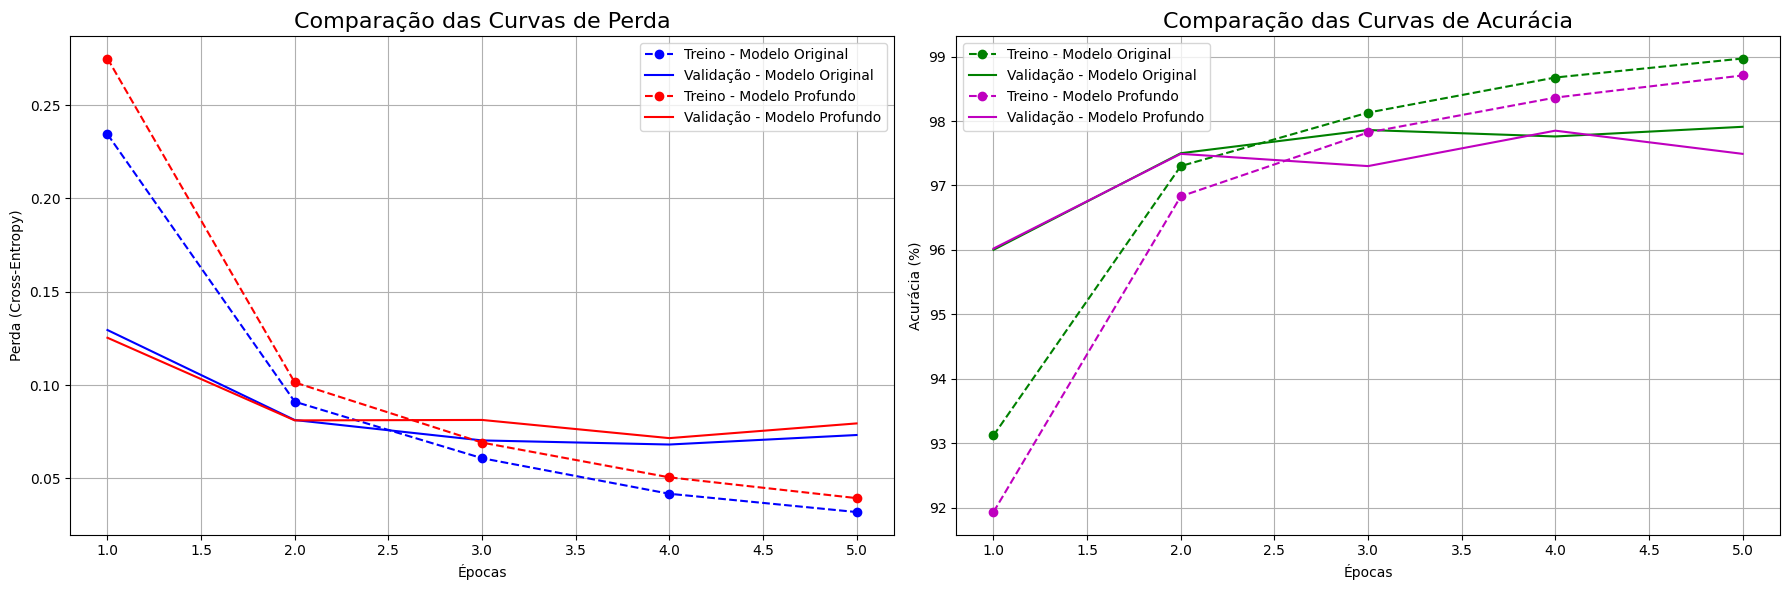

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

# Definição das transformações para os dados
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # Média e desvio padrão do MNIST
])

# Baixa os datasets
train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, transform=transform, download=True
)
test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, transform=transform
)

# Criação dos DataLoaders
batch_size = 128
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# --- DEFINIÇÃO DAS ARQUITETURAS DOS MODELOS ---

# Modelo Original
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        return out

# Modelo modificado
class NeuralNetworkDeeper(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(NeuralNetworkDeeper, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(hidden_size2, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.relu1(out)
        out = self.layer2(out)
        out = self.relu2(out)
        out = self.layer3(out)
        return out

# Treinamento
def train_model(model, model_name, device):
    print(f"--- Iniciando Treinamento para: {model_name} ---")

    # Mover modelo para o dispositivo
    model.to(device)

    # Função de custo e otimizador
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Listas para armazenar métricas
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }

    num_epochs = 5
    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0
        for images, labels in train_loader:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100 * correct_train / total_train
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)

        # Validação
        model.eval()
        running_val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.reshape(-1, 28*28).to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_val_loss / len(test_loader)
        epoch_val_acc = 100 * correct_val / total_val
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        print(f'Época [{epoch+1}/{num_epochs}] | '
              f'Perda Treino: {epoch_train_loss:.4f}, Acurácia Treino: {epoch_train_acc:.2f}% | '
              f'Perda Val: {epoch_val_loss:.4f}, Acurácia Val: {epoch_val_acc:.2f}%')

    print(f"--- Treinamento Concluído para: {model_name} ---\n")
    return history

# Comparação

# Configurações
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = 784
num_classes = 10

# Instancia e treina o Modelo 1
model_1_layer = NeuralNetwork(input_size=input_size, hidden_size=500, num_classes=num_classes)
history_1_layer = train_model(model_1_layer, "Modelo Original (1 Camada Oculta)", device)

# Instancia e treina o Modelo 2
model_2_layers = NeuralNetworkDeeper(input_size=input_size, hidden_size1=256, hidden_size2=128, num_classes=num_classes)
history_2_layers = train_model(model_2_layers, "Modelo Profundo (2 Camadas Ocultas)", device)

# Plotagem das curvas de aprendizado

fig, axs = plt.subplots(1, 2, figsize=(18, 6))
epochs = range(1, len(history_1_layer['train_loss']) + 1)

# Gráfico de Perda (Loss)
axs[0].plot(epochs, history_1_layer['train_loss'], 'bo--', label='Treino - Modelo Original')
axs[0].plot(epochs, history_1_layer['val_loss'], 'b-', label='Validação - Modelo Original')
axs[0].plot(epochs, history_2_layers['train_loss'], 'ro--', label='Treino - Modelo Profundo')
axs[0].plot(epochs, history_2_layers['val_loss'], 'r-', label='Validação - Modelo Profundo')
axs[0].set_title("Comparação das Curvas de Perda", fontsize=16)
axs[0].set_xlabel("Épocas")
axs[0].set_ylabel("Perda (Cross-Entropy)")
axs[0].legend()
axs[0].grid(True)

# Gráfico de Acurácia
axs[1].plot(epochs, history_1_layer['train_acc'], 'go--', label='Treino - Modelo Original')
axs[1].plot(epochs, history_1_layer['val_acc'], 'g-', label='Validação - Modelo Original')
axs[1].plot(epochs, history_2_layers['train_acc'], 'mo--', label='Treino - Modelo Profundo')
axs[1].plot(epochs, history_2_layers['val_acc'], 'm-', label='Validação - Modelo Profundo')
axs[1].set_title("Comparação das Curvas de Acurácia", fontsize=16)
axs[1].set_xlabel("Épocas")
axs[1].set_ylabel("Acurácia (%)")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

#### Exercício 3: Otimizadores e Taxa de Aprendizado

Altere a taxa de aprendizado no loop de treinamento. Utilize valores maiores (como `lr=1.0`) e menores (como `lr=0.0001`) do que o original. Como as curvas de treinamento se comportaram em cada ocasião?

--- Iniciando Treinamento para: LR = 1.0 ---
Época [1/5], Perda Val: 2.7074, Acurácia Val: 12.66%
Época [2/5], Perda Val: 3.1818, Acurácia Val: 11.06%
Época [3/5], Perda Val: 2.6809, Acurácia Val: 11.40%
Época [4/5], Perda Val: 2.7269, Acurácia Val: 11.58%
Época [5/5], Perda Val: 3.0551, Acurácia Val: 10.52%
--- Treinamento Concluído para: LR = 1.0 ---

--- Iniciando Treinamento para: LR = 0.001 ---
Época [1/5], Perda Val: 0.1087, Acurácia Val: 96.55%
Época [2/5], Perda Val: 0.0843, Acurácia Val: 97.48%
Época [3/5], Perda Val: 0.0717, Acurácia Val: 97.64%
Época [4/5], Perda Val: 0.0704, Acurácia Val: 97.73%
Época [5/5], Perda Val: 0.0642, Acurácia Val: 97.99%
--- Treinamento Concluído para: LR = 0.001 ---

--- Iniciando Treinamento para: LR = 0.0001 ---
Época [1/5], Perda Val: 0.2797, Acurácia Val: 92.17%
Época [2/5], Perda Val: 0.2119, Acurácia Val: 94.04%
Época [3/5], Perda Val: 0.1722, Acurácia Val: 95.03%
Época [4/5], Perda Val: 0.1456, Acurácia Val: 95.92%
Época [5/5], Perda Val: 

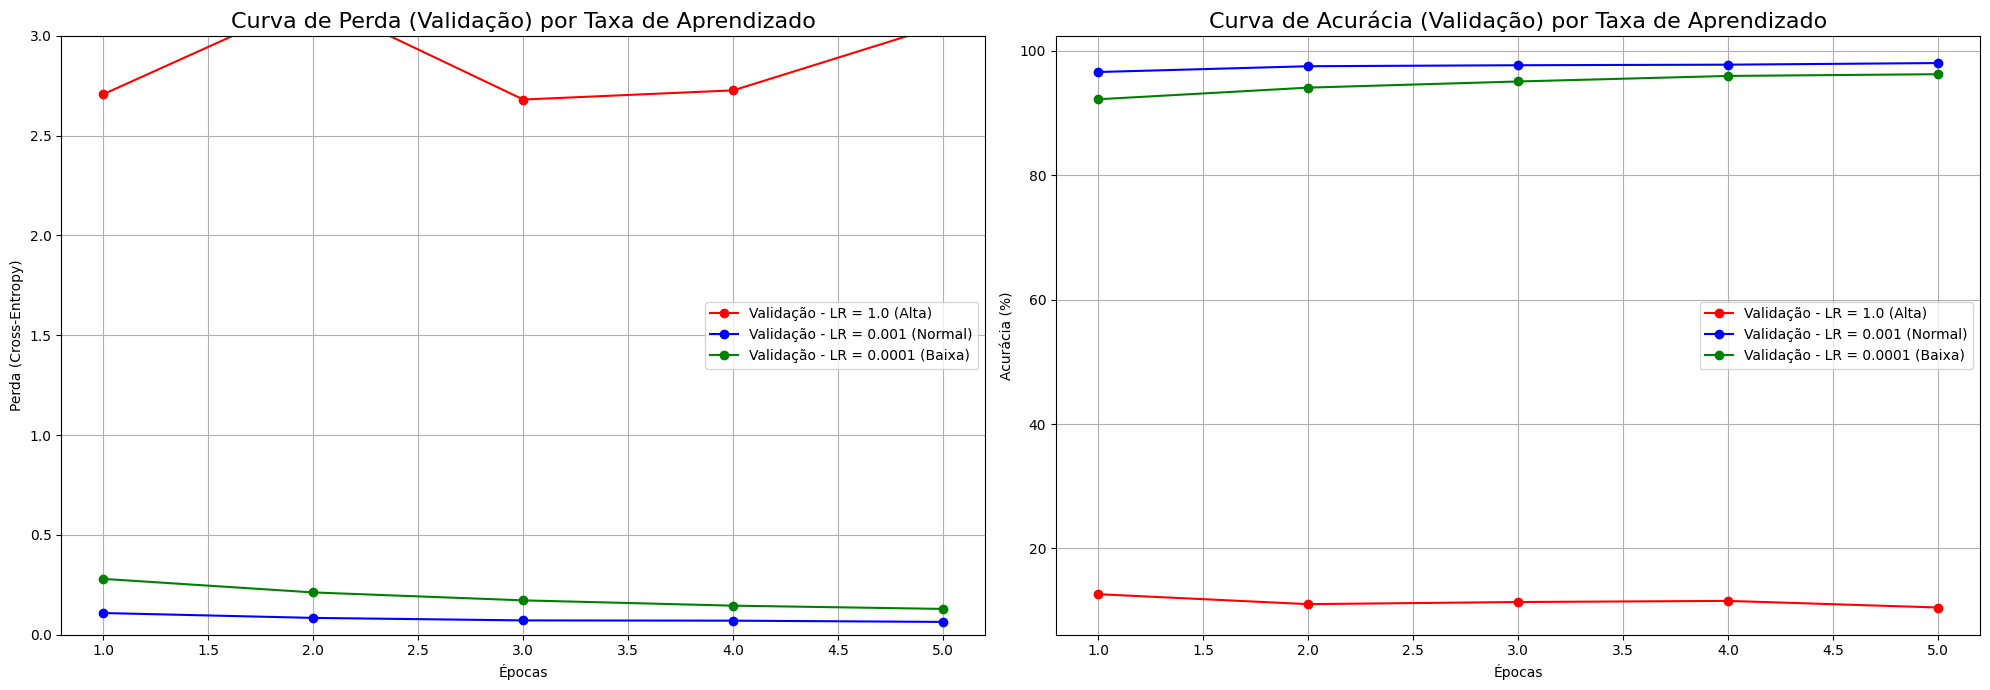

In [4]:
def train_with_lr(model_class, learning_rate, device):
    # Cria uma nova instância do modelo para garantir um treino limpo
    model_instance = model_class()

    model_name = f"LR = {learning_rate}"
    print(f"--- Iniciando Treinamento para: {model_name} ---")

    model_instance.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model_instance.parameters(), lr=learning_rate)

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    num_epochs = 5

    for epoch in range(num_epochs):
        model_instance.train()
        running_loss, correct_train, total_train = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.reshape(-1, 28*28).to(device), labels.to(device)
            outputs = model_instance(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader)
        history['train_loss'].append(epoch_train_loss)

        model_instance.eval()
        running_val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.reshape(-1, 28*28).to(device), labels.to(device)
                outputs = model_instance(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_val_loss / len(test_loader)
        epoch_val_acc = 100 * correct_val / total_val
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        print(f'Época [{epoch+1}/{num_epochs}], Perda Val: {epoch_val_loss:.4f}, Acurácia Val: {epoch_val_acc:.2f}%')

    print(f"--- Treinamento Concluído para: {model_name} ---\n")
    return history

# --- EXECUÇÃO DOS TRÊS TREINAMENTOS ---

model_builder = lambda: NeuralNetwork(input_size=784, hidden_size=500, num_classes=10)

# Treinamento com as três taxas de aprendizado
history_high_lr = train_with_lr(model_builder, learning_rate=1.0, device=device)
history_normal_lr = train_with_lr(model_builder, learning_rate=0.001, device=device)
history_low_lr = train_with_lr(model_builder, learning_rate=0.0001, device=device)

# --- PLOT COMPARATIVO ---

fig, axs = plt.subplots(1, 2, figsize=(20, 7))
epochs = range(1, 6)

# Gráfico de Perda (Loss)
axs[0].plot(epochs, history_high_lr['val_loss'], 'r-o', label='Validação - LR = 1.0 (Alta)')
axs[0].plot(epochs, history_normal_lr['val_loss'], 'b-o', label='Validação - LR = 0.001 (Normal)')
axs[0].plot(epochs, history_low_lr['val_loss'], 'g-o', label='Validação - LR = 0.0001 (Baixa)')
axs[0].set_title("Curva de Perda (Validação) por Taxa de Aprendizado", fontsize=16)
axs[0].set_xlabel("Épocas")
axs[0].set_ylabel("Perda (Cross-Entropy)")
axs[0].set_ylim(0, 3) # Limite no eixo Y para melhor visualização
axs[0].legend()
axs[0].grid(True)

# Gráfico de Acurácia
axs[1].plot(epochs, history_high_lr['val_acc'], 'r-o', label='Validação - LR = 1.0 (Alta)')
axs[1].plot(epochs, history_normal_lr['val_acc'], 'b-o', label='Validação - LR = 0.001 (Normal)')
axs[1].plot(epochs, history_low_lr['val_acc'], 'g-o', label='Validação - LR = 0.0001 (Baixa)')
axs[1].set_title("Curva de Acurácia (Validação) por Taxa de Aprendizado", fontsize=16)
axs[1].set_xlabel("Épocas")
axs[1].set_ylabel("Acurácia (%)")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

Taxa de Aprendizado Alta (lr=1.0): Uma taxa de aprendizado tão alta faz com que o otimizador dê passos muito grandes no espaço de parâmetros. A curva de perda é extremamente instável e irregular. Os valores oscilam violentamente. A acurácia apresenta um resultado muito ruim. Ela pula aleatoriamente e permanece em níveis baixos, pois o modelo não consegue convergir para uma boa solução.

Taxa de Aprendizado Baixa (lr=0.0001): Com uma taxa de aprendizado pequena, os passos de atualização dos pesos são muito cautelosos. O modelo aprende, mas de forma muito lenta. As curvas de perda de treino e validação diminuem de forma muito suave e lenta. Após o mesmo número de épocas do treinamento original, o valor da perda final é consideravelmente mais alto. A acurácia aumenta de forma constante, mas muito devagar. Ao final das 5 épocas, a acurácia final é um pouco menor do que a obtida com a taxa de aprendizado de 0.001.

#### Exercício 4: Criando um Dataset para Regressão

Crie uma classe de `Dataset` customizada para um problema de regressão simples. O dataset deve gerar dados sintéticos onde `y` é uma função linear de `x` com um pouco de ruído.

Crie uma classe `RegressionDataset` que herde de `torch.utils.data.Dataset`. No `__init__`, crie um tensor `X` com 1000 pontos aleatórios entre -10 e 10 e crie um tensor `y` correspondente usando a fórmula $y = 5x - 3 + \text{ruído}$ (use `torch.randn` para o ruído). Implemente os métodos `__len__` e `__getitem__` e use um `DataLoader` para extrair o primeiro lote (batch). Imprima o formato dos tensores de features e labels do lote para confirmar que seu pipeline de dados está funcionando corretamente.

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader

class RegressionDataset(Dataset):
    def __init__(self, num_samples=1000):
        super().__init__()
        # Cria um tensor X com 'num_samples' pontos aleatórios entre -10 e 10
        self.X = torch.rand(num_samples, 1) * 20 - 10

        # Adiciona o ruído com a mesma forma de X
        noise = torch.randn(num_samples, 1) * 2 # Aumenta um pouco a variância do ruído

        # Cria o tensor y
        self.y = 5 * self.X - 3 + noise

    def __len__(self):
        # Retorna o número total de amostras
        return len(self.X)

    def __getitem__(self, idx):
        # Retorna uma tupla (feature, label) para o índice dado
        return self.X[idx], self.y[idx]

# Instancia o dataset
regression_dataset = RegressionDataset(num_samples=1000)

# Verifica o tamanho e uma amostra
print(f"Tamanho total do dataset: {len(regression_dataset)}")
sample_x, sample_y = regression_dataset[0]
print(f"Primeira amostra (X): {sample_x}, (y): {sample_y}\n")

# Usa um DataLoader para criar lotes
batch_size = 64
data_loader = DataLoader(dataset=regression_dataset, batch_size=batch_size, shuffle=True)

# Extrai o primeiro lote do DataLoader
features_batch, labels_batch = next(iter(data_loader))

# Imprime o formato dos tensores do lote
print(f"--- Usando o DataLoader com batch_size={batch_size} ---")
print(f"Formato do lote de features (X): {features_batch.shape}")
print(f"Formato do lote de labels (y): {labels_batch.shape}")

Tamanho total do dataset: 1000
Primeira amostra (X): tensor([-2.2668]), (y): tensor([-8.6711])

--- Usando o DataLoader com batch_size=64 ---
Formato do lote de features (X): torch.Size([64, 1])
Formato do lote de labels (y): torch.Size([64, 1])
